In [1]:
!pip install torchvision

Accuracy: 81.94%


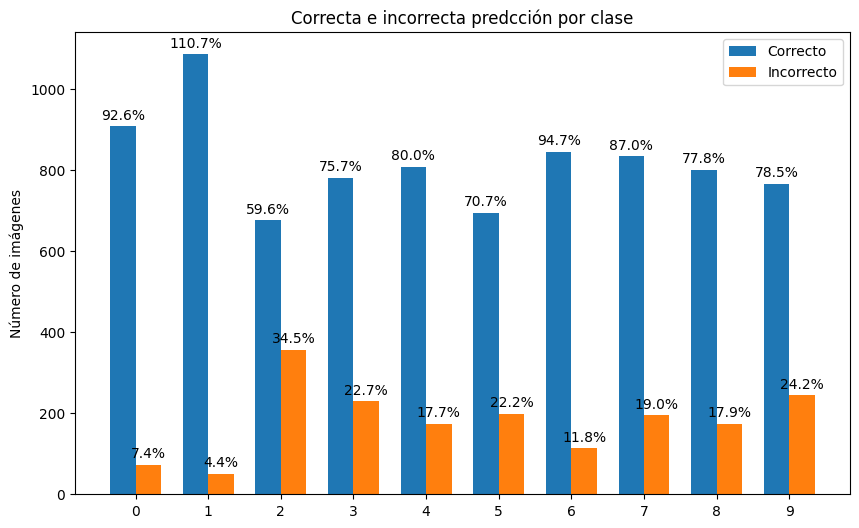

In [3]:
# Importar las librerías necesarias
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Instanciar un modelo pre-entrenado
transfer_model = torchvision.models.resnet50(pretrained=True)

# Congelar los pesos del modelo
for name, param in transfer_model.named_parameters():
    param.requires_grad = False

# Añadir una nueva capa lineal al final del modelo
num_features = transfer_model.fc.in_features # Número de características de entrada de la última capa
num_classes = 10 # MNIST tiene 10 clases (dígitos del 0 al 9)
transfer_model.fc = torch.nn.Linear(num_features, num_classes) # Crear una capa lineal con 10 unidades de salida

# Mover el modelo y los pesos a la GPU
transfer_model = transfer_model.cuda() # Mover el modelo a la GPU
for name, param in transfer_model.named_parameters():
    param = param.cuda() # Mover cada peso a la GPU

# Definir una función que repite el canal único 3 veces
def repeat_channel(x):
    return x.repeat(3, 1, 1) # Repetir el tensor a lo largo de la dimensión de los canales

# Definir la transformación que aplica la función
repeat_transform = torchvision.transforms.Lambda(repeat_channel) # Crear una transformación que aplica la función

# Definir los datos de entrenamiento
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.Resize((28, 28)), torchvision.transforms.Grayscale(), torchvision.transforms.ToTensor(), repeat_transform])) # Descargar y transformar los datos de entrenamiento de MNIST
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128) # Crear un cargador de datos con un tamaño de lote de 128

# Definir la función de pérdida y el optimizador
criterion = torch.nn.CrossEntropyLoss() # Usar la pérdida de entropía cruzada para clasificación multiclase
optimizer = torch.optim.Adam(transfer_model.parameters(), lr=0.001) # Usar el optimizador Adam con una tasa de aprendizaje de 0.001

# Entrenar el modelo
for epoch in range(10): # Repetir el proceso 10 veces (épocas)
    for images, labels in train_loader: # Iterar sobre los lotes de imágenes y etiquetas
        images = images.cuda() # Mover las imágenes a la GPU
        labels = labels.cuda() # Mover las etiquetas a la GPU

        # Paso hacia adelante
        outputs = transfer_model(images) # Obtener las salidas del modelo para las imágenes de entrada
        loss = criterion(outputs, labels) # Calcular la pérdida entre las salidas y las etiquetas verdaderas

        # Paso hacia atrás
        optimizer.zero_grad() # Poner a cero los gradientes acumulados
        loss.backward() # Calcular los gradientes de la pérdida con respecto a los pesos del modelo
        optimizer.step() # Actualizar los pesos del modelo usando el optimizador

# Probar el modelo
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.Resize((28, 28)), torchvision.transforms.Grayscale(), torchvision.transforms.ToTensor(), repeat_transform])) # Descargar y transformar los datos de prueba de MNIST
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128) # Crear un cargador de datos con un tamaño de lote de 128

correct = 0 # Contador para el número de predicciones correctas
total = 0 # Contador para el número total de imágenes
with torch.no_grad(): # Desactivar el cálculo de gradientes para ahorrar memoria y tiempo
    for images, labels in test_loader: # Iterar sobre los lotes de imágenes y etiquetas
        images = images.cuda() # Mover las imágenes a la GPU
        labels = labels.cuda() # Mover las etiquetas a la GPU

        outputs = transfer_model(images) # Obtener las salidas del modelo para las imágenes de entrada
        _, predicted = torch.max(outputs.data, 1) # Obtener las predicciones como la clase con mayor probabilidad
        total += labels.size(0) # Aumentar el contador total con el número de imágenes en el lote
        correct += (predicted == labels).sum().item() # Aumentar el contador correcto con el número de predicciones que coinciden con las etiquetas verdaderas

print('Accuracy: {}%'.format(100 * correct / total)) # Imprimir la precisión como el porcentaje de predicciones correctas sobre el total

# Crear un array para almacenar el número de predicciones correctas e incorrectas por clase
class_correct = np.zeros(10) # Array de ceros para las predicciones correctas
class_total = np.zeros(10) # Array de ceros para el total de imágenes por clase

# Recorrer los datos de prueba y actualizar el array
with torch.no_grad(): # Desactivar el cálculo de gradientes
    for images, labels in test_loader: # Iterar sobre los lotes de imágenes y etiquetas
        images = images.cuda() # Mover las imágenes a la GPU
        labels = labels.cuda() # Mover las etiquetas a la GPU

        outputs = transfer_model(images) # Obtener las salidas del modelo para las imágenes de entrada
        _, predicted = torch.max(outputs.data, 1) # Obtener las predicciones como la clase con mayor probabilidad
        c = (predicted == labels).squeeze() # Crear un tensor booleano que indica si la predicción coincide con la etiqueta
        for i in range(labels.size(0)): # Iterar sobre cada imagen y etiqueta en el lote
            label = labels[i] # Obtener la etiqueta verdadera
            class_correct[label] += c[i].item() # Aumentar el contador de predicciones correctas para esa clase
            class_total[label] += 1 # Aumentar el contador total de imágenes para esa clase

# Crear una figura y un subplot
plt.figure(figsize=(10, 6)) # Crear una figura con un tamaño de 10 x 6 pulgadas
ax = plt.subplot() # Crear un subplot dentro de la figura

# Crear un gráfico de barras con las predicciones correctas e incorrectas por clase
width = 0.35 # Ancho de las barras
x = np.arange(10) # Posiciones de las barras en el eje x
rects1 = ax.bar(x - width/2, class_correct, width, label='Correcto') # Crear las barras para las predicciones correctas
rects2 = ax.bar(x + width/2, class_total - class_correct, width, label='Incorrecto') # Crear las barras para las predicciones incorrectas

# Añadir texto para las etiquetas, el título y las marcas personalizadas del eje x, etc.
ax.set_ylabel('Número de imágenes') # Poner una etiqueta al eje y
ax.set_title('Correcta e incorrecta predcción por clase') # Poner un título al gráfico
ax.set_xticks(x) # Poner las marcas en el eje x
ax.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']) # Poner las etiquetas en el eje x
ax.legend() # Mostrar la leyenda

# Anotar las barras con el porcentaje de precisión por clase
def autolabel(rects):
    for rect in rects: # Iterar sobre cada barra
        height = rect.get_height() # Obtener la altura de la barra
        # Redondear el índice al entero más cercano
        index = int(rect.get_x() + rect.get_width() / 2)
        ax.annotate('{:.1f}%'.format(100 * height / class_total[index]), # Calcular y formatear el porcentaje de precisión para esa clase
                    xy=(rect.get_x() + rect.get_width() / 2, height), # Poner la posición de la anotación en el centro y arriba de la barra
                    xytext=(0, 3),  # Desplazar la anotación 3 puntos verticalmente
                    textcoords="offset points", # Usar coordenadas relativas para el desplazamiento
                    ha='center', va='bottom') # Alinear la anotación horizontal y verticalmente

autolabel(rects1) # Anotar las barras de las predicciones correctas
autolabel(rects2) # Anotar las barras de las predicciones incorrectas

# Mostrar el gráfico
plt.show()
